## Exploratory Analysis

We will perform in this notebook an exploratory analysis of our data. Let's start with the English dataset.

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df = pd.read_table("../data/English/task_a_distant.tsv", index_col=0)

/home/jmperez/.local/share/virtualenvs/offenseval2020-HKdlw5Be/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [2]:
df.shape

(9075418, 3)

Citing the README

```
- AVG_CONF is the average of the confidences predicted by several supervised models for a specific instance to belong to the positive class for that subtask. The positive class is OFF for subtask A, and UNT for subtask B.

- CONF_STD is the confidences' standard deviation from AVG_CONF for a particular instance.
```

In [3]:
pd.options.display.max_colwidth = 1000
df[:2]

,text,average,std
id,,,
1159533701283352576,"First time I heard his name in camp, he seems to be the forgotten guyChristian Covington being disruptive so far today",0.195773,0.187379
1159533703522992128,When I go to drink with Tsubaki he would always fall asleep first. His sleeping face looks really innocent and not like him at all. Fufu♪,0.262401,0.145998


Let's look for some instances with high average confidence for the models

In [4]:
df[df["average"] > 0.9][:3]

,text,average,std
id,,,
1159469570912137216,Invest in your bitch,0.912992,0.128156
1159528564925984768,everyone talks shit in LA,0.900464,0.126209
1159538776357711874,@USER @USER this is dumb as shit,0.927991,0.074608


## Distribution of confidences

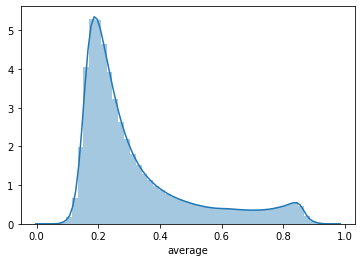

In [9]:
import seaborn as sns

sns.distplot(df["average"]);

What about the stds?

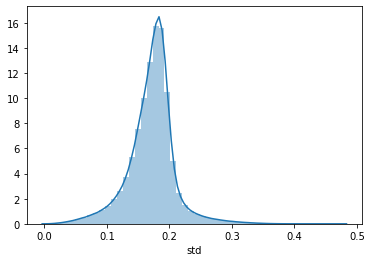

In [10]:
sns.distplot(df["std"])

Remember that given the mean $\mu$ and the std $\sigma$ (and asumming normality of the data) we have the predictions with a 0.68 confidence interval in $(\mu-\sigma, \mu+\sigma)$, and a 0.95 if two sigma are taken.

A simple approach I think would be to do the following:

- First, keep just the tweets with $\sigma \leq \epsilon$ ($\epsilon$ could be, 0.15)
- Label as offensive those with $\mu > (0.5 + \epsilon)$, so you got at least a 0.68 confidence interval that the mean is above 0.5
- Label as not offensive those with $\mu < 0.5 - \epsilon$ for the same reason
- Discard the others

Another strategy would be to fit our models using real cross entropy loss. That is, instead of training against a binary label use `average` as target output. 